In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");
colors = sns.color_palette()


# ME 270 - Activity 2 - Investigation of uncertainty in stress-strain calculations

In this activity, we will learn how to propagate uncertainty in stress-strain calculations. Engineering real systems must account for variability in material properties, applied forces, and geometric dimensions, as these factors influence performance and safety. In this activity, we will model uncertainty in axial loading and cross-sectional dimensions, observing how these variations affect stress, strain, and the Factor of Safety (FS). By using a Monte Carlo simulation, we will generate random samples for force and diameter, compute stress and FS for each case, and analyze the resulting probability distributions. This approach helps engineers design robust systems that remain safe under real-world variability, ensuring reliability even in the presence of uncertainty.

### Question 1: Review of stress and strain calculations

We are first going to take a look at a familiar problem and remind ourselves of the calculaions involved in determining the stress and strain in a rod under axial loading.

<figure>
 <img src="https://raw.githubusercontent.com/ebilionis/core-me-data-science-activities-public/refs/heads/main/images/Statics_31B.png" width="700" height="300">
</figure>

I will remind you by walking you through the solution for the first member of the rod.

We start with a force balance in the x-direction:

$$
\sum F_x = 0
$$

$$
F_{BC} - 3P = 0
$$

$$
F_{BC} = 3P
$$

In [2]:
# Applied force is given to be 50 kips
P = 50 # kips

# The force in member BC is 3 times the applied force
F_bc = 3*P # kips
print(f"Reaction force in member B is {F_bc} kips")

Reaction force in member B is 150 kips


Let's go ahea and calculate the stress in the rod.

$$
\sigma_{BC} = \frac{F_{BC}}{A_{BC}}
$$

We can create a function to help us not repeat the calculation for each member.

In [3]:
def calc_stress(F, d):
    """Calculate the stress in a member given the force and diameter"""
    A = np.pi * (d/2)**2
    return F/A

# Diameter is given to be 3in
d = 3 # in

# Calculate the stress in member BC
stress_bc = calc_stress(F_bc, d)
print(f"Stress in member BC is {stress_bc:.2f} ksi")

Stress in member BC is 21.22 ksi


Now calculate the strain in the rod.

$$
\epsilon_{BC} = \frac{\sigma_{BC}}{E}
$$

Where $E$ is the modulus of elasticity of the material.

In [4]:
def calc_strain(sigma, E):
    """Calculate the strain in a member given the stress and modulus of elasticity"""
    return sigma / E

# Modulus of elasticity is given to be 10x10^4 ksi
E = 10e4 # ksi

# Calculate the strain in member BC
strain_bc = calc_strain(stress_bc, E)
print(f"Strain in member BC is {strain_bc:.5f}")

Strain in member BC is 0.00021


Finally, lets find the factor of safety for the rod against yielding.

$$
FS = \frac{\sigma_{failure}}{\sigma_{applied}}
$$

Where $\sigma_{failure}$ is the yield strength of the material.

In [5]:
def calc_FS(sigma, sigma_yield):
    """Calculate the factor of safety given the stress and yield stress"""
    return sigma_yield / sigma

# Yield stress is given to be 40 ksi
stress_yield = 40 # ksi

# Calculate the factor of safety in member BC
FS_bc = calc_FS(stress_bc, stress_yield)
print(f"Factor of safety in member BC is {FS_bc:.2f}")

Factor of safety in member BC is 1.88


We can use a simple conditional statement to determine if the rod will fail or not.

In [6]:
# Check if member BC has failed
if FS_bc < 1:
    print("Member BC has failed")
else:
    print("Member BC has not failed")

Member BC has not failed


Now I want you to recall what you learned about loops in Python. I am going to give you the reaction forces in each member of the rod as a list. I want you to calculate the stress, strain, and factor of safety of each member in the rod.

In [7]:
# Calculated from a force balance on the different members
F_cd = 2*P # kips
F_dh = P # kips

# Place the data in lists to loop through
members = ["BC", "CD", "DH"]
forces = [F_bc, F_cd, F_dh]
diameters = [d, 2*d, 3*d]

In [8]:
# YOUR CODE HERE

### Question 2: Pseudo-random numbers

Before we can talk about uncertainty in our calculations, we need to understand that there is no true randomness in a computer. They are completely deterministic machines. 

So how are we going to introduce randomness into our calculations? We can use pseudo-random number generators (PRNG). These are algorithms that generate numbers that appear to be random. The numbers are not truly random, but they are generated in such a way that they appear to be random. The numbers are generated based on a seed value. The seed value is the starting point for the algorithm. If you use the same seed value, you will get the same sequence of numbers. If you use a different seed value, you will get a different sequence of numbers. 

Let's take a look at the most simple PRNG, called the middle-square method. The middle-square method works as follows:

1. Start with a seed value, $X_0$.
2. Square the seed value, $X_0^2$.
3. Pad the square of the seed value with zeros to make it the desired length.
4. Take the middle digits of the padded number as the next value, $X_1$.
5. Repeat steps 2-4 as many times as you want.

Let me build this function for you.

In [10]:
def middlesquare(s : int, digits : int = 4):
    """Sample random numbers using the middle square algorithm.
    
    Arguments:
        s      -- The initial seed.
        digits -- How many digits do you want.
    """
    # Square the number
    s2 = s ** 2
    # Turn the resulting number into a string padding
    # with zeros to get to the desired number of digits
    s2_str = str(s2).zfill( 2 * digits)
    # Keep only the middle
    middle_str = s2_str[int(np.floor(digits/2)):][:-int(np.floor(digits/2))]
    return int(middle_str)

We will give it a seed value of 1234 and generate 5 random numbers.

In [11]:
# Seed the random number generator
x0 = 1234
x = x0

# Generate 5 "random" numbers using a for loop
for i in range(5):
    x = middlesquare(x)
    print(x)

5227
3215
3362
3030
1809


That looks pretty random, right? The problem with the middle-square method is that depending ont the seed value, you can get stuck in a loop, and the numbers generated will not be very random at all. For example:

In [12]:
# Bad seed
x0 = 540
x = x0

# Show the middle square algorithm is not very good
for i in range(20):
    x = middlesquare(x)
    print(x)

2916
5030
3009
540
2916
5030
3009
540
2916
5030
3009
540
2916
5030
3009
540
2916
5030
3009
540


You can see that the numbers begin to repeat after a few iterations. This is not good for our purposes. We need a better PRNG. How about you make one for us? 

A relatively simple PRNG is the *linear congruential generator* (LCG). The LCG works as follows:

$$
X_{n+1} = (aX_n + b) \mod m
$$

Again you'll want to seed our PRNG with a value. The values $a$, $b$, and $m$ are constants that you can choose. Mod is the modulus operator, which gives the remainder of a division operation (in Python, this is the % operator). 

Write a python function that generates random numbers using the LCG. You can choose the values of $a$, $b$, and $m$ I would recommend choosing decently large numbers, at least a few digits, but don't worry too much about the values. 

In [13]:
# YOUR CODE HERE

Generate 10 random numbers using a for loop like we did with the middle-square method. Feel free to experiment with different seeds and see if they appear to be random.

In [15]:
# YOUR CODE HERE

What happens if you set m to be a small number? Does this seem to be a good PRNG?

*YOUR ANSWER HERE*

The [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister) is a very good PRNG that is used in many applications. It is the default PRNG in Python. Let's use the Mersenne Twister to generate 10 random numbers, and save them in an array.

In [17]:
X = []
for i in range(10):
    x = np.random.randint(0, 10000)
    X.append(x)

# You can easily turn a list into a numpy array
X = np.array(X)
print(X)

[3049 3582 3306 5373 5302 1515  153 5535  899 2098]


### Question 3: Probability distributions

Now that we have a good PRNG, we can generate random numbers that seem truly random. But what do we do with these random numbers? We can use them to generate random variables that follow a probability distribution. We are going to look at two probability distributions: the uniform distribution and the normal distribution.

Let's start with the Uniform distribution. The Uniform distribution is the simplest probability distribution. It is defined by two parameters, $a$ and $b$, which are the lower and upper bounds of the distribution. We say that a random variable $X$ follows a uniform distribution, notated as: 

$$
X \sim U(a, b)
$$

With the Uniform distribution, all values between $a$ and $b$ are equally likely. The probility density function (PDF) tells us the probability of a random variable taking on a certain value. For the Uniform distribution, the pdf is:

$$
f(x) = \frac{1}{b - a}
$$

Let's visualize the PDF of the Uniform distribution with $a = 0$ and $b = 1$.

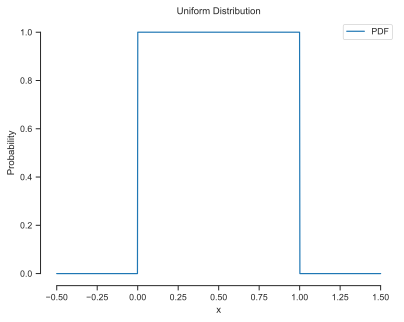

In [18]:
standard_uniform = stats.uniform(0, 1)
x = np.linspace(-0.5, 1.5, 1000)
y = standard_uniform.pdf(x)

fig, ax = plt.subplots()
ax.plot(x, y, label="PDF")
ax.set_xlabel("x")
ax.set_ylabel("Probability")
ax.set_title("Uniform Distribution")
ax.legend()
sns.despine(trim=True)
plt.show()

We can take samples from the Uniform distribution using the `numpy.random.uniform` function. Let's generate 1000 samples from the Uniform distribution and plot a histogram of the samples.

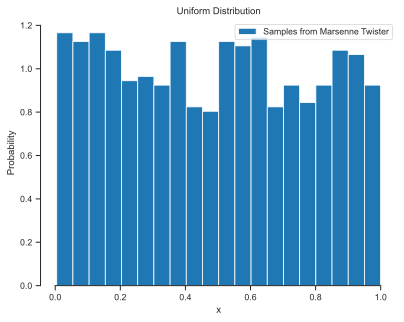

In [19]:
# Set the number of samples that we want to generate
num_samples = 1000

# Seed the PRNG as we have learned - change to see different results
np.random.seed(42)

MT_samples = np.random.uniform(0, 1, num_samples)

fig, ax = plt.subplots()
ax.hist(MT_samples, bins=20, density=True, label="Samples from Marsenne Twister")
ax.set_xlabel("x")
ax.set_ylabel("Probability")
ax.set_title("Uniform Distribution")
ax.legend()
sns.despine(trim=True)
plt.show()

You can actually generate samples from a Uniform distribution using the linear congruential generator that you built in the previous question. To normalize the random numbers to be between 0 and 1, you can divide the random numbers by the modulus, $m$. Generate 1000 random numbers and plot a histogram of the random numbers. Does it look like a uniform distribution?

In [20]:
# YOUR CODE HERE

How can we tell which PRNG samples the Uniform distribution better? We can look at what is called the empirical cumulative distribution function (ECDF). The ECDF is a function that tells us the probability that a random variable is less than or equal to a certain value. We can plot the ECDF of the samples from the Uniform distribution and compare it to the ECDF of the samples from our two PRNGs.

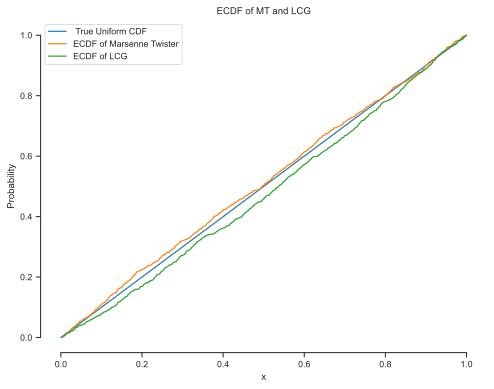

In [34]:
def ecdf(x):
    """The empirical distribution function of scalar samples.
    
    From: https://stackoverflow.com/questions/15792552/numpy-scipy-equivalent-of-r-ecdfxx-function
    """
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

# Compute the ECDF of the samples
xs, ys = ecdf(MT_samples)
xs2, ys2 = ecdf(lcg_X)

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the true CDF of the uniform distribution
ax.plot(np.linspace(0, 1), np.linspace(0, 1), label=" True Uniform CDF")
ax.plot(xs, ys, label="ECDF of Marsenne Twister")
ax.plot(xs2, ys2, label="ECDF of LCG")
ax.set_xlabel("x")
ax.set_ylabel("Probability")
ax.set_title("ECDF of MT and LCG")
ax.legend()
sns.despine(trim=True)
plt.show()

Great, if you look closely at the ECDFs, you can see that the Mersenne Twister samples the Uniform distribution better than the LCG.

These sorts of statistical tests are very important when working with random variables.

Great, if you look closely at the ECDFs, you can see that the Mersenne Twister samples the Uniform distribution better than the LCG.

These sorts of statistical tests are very important when working with random variables.

### Question 4: Propagating uncertainty through a physical system

Let's go back to our rod problem. Imagine that our rod is a landing gear strut in an aircraft. When the plane lands, the force P fluctuates due to variations in speed, ground impact, and pilot technique. This small variation in P affects stress, strain, and ultimately the Factor of Safety. If P gets too high, stress might exceed the material's yield strength, leading to potential failure. Engineers must design conservatively, ensuring that even the largest reasonable P still results in a safe FS. By running simulations with varying P, we can visualize how uncertainty propagates and impacts failure risk, a critical concept in real-world engineering design. This kind of simulation is called a Monte Carlo simulation.

Let's vary P with a uniform distribution 50 and 100 kips, imagining that 50 kips is the empty plane and 100 kips is the plane fully loaded. Let's take a look at this histogram.

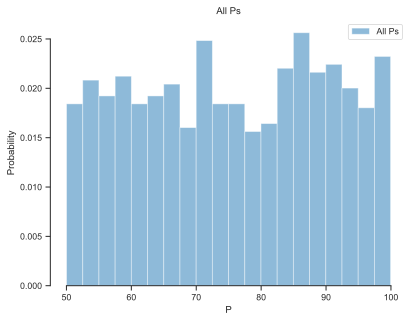

In [23]:
# Create a list to store all the values of P
all_Ps = []

# Uses system entropy for randomness so we will see different monte carlo results
np.random.seed(None)  


# Get 1000 random values of P sampled from a uniform distribution
num_samples = 1000
for _ in range(num_samples):
    P = np.random.uniform(50, 100)
    all_Ps.append(P)

# Turn the list into a numpy array
all_Ps = np.array(all_Ps)

# Plot the histogram of all the values of P
fig, ax = plt.subplots()
ax.hist(all_Ps, bins=20, density=True, alpha=0.5, label="All Ps")
ax.set_xlabel("P")
ax.set_ylabel("Probability")
ax.set_title("All Ps")
ax.legend()
sns.despine(trim=True)
plt.show()


Great, let's start by looking at member BC and how the reaction force will change from the varying P.

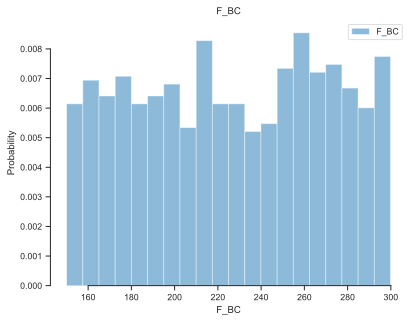

In [24]:
# Calculate the reaction forces
F_BCs = 3*all_Ps

# Plot the histogram
fig, ax = plt.subplots()
ax.hist(F_BCs, bins=20, density=True, alpha=0.5, label="F_BC")
ax.set_xlabel("F_BC")
ax.set_ylabel("Probability")
ax.set_title("F_BC")
ax.legend()
sns.despine(trim=True)
plt.show()

We can see that the 50 kip variation in P results in a 150 kip variation in F_BC. This variation in F_BC will propagate through the rod, affecting all our other calculations. Let's calculate the stress, strain, and factor of safety for each member in the rod for the 50 kip P.

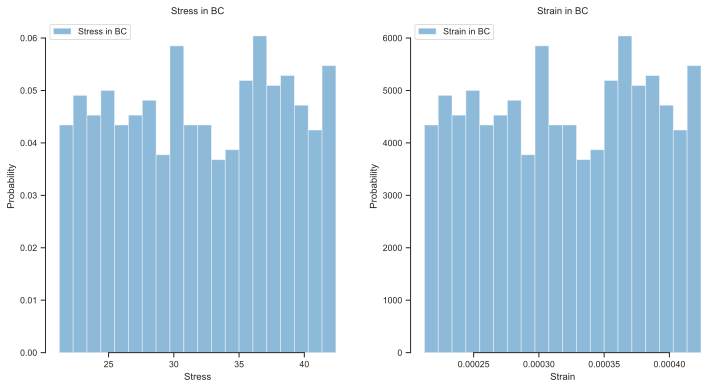

In [25]:
# Use our previously defined function to calculate the stress
stress_bc = calc_stress(F_BCs, d)

# Calculate the strain
strain_bc = calc_strain(stress_bc, E)

# Plot the histograms for the stress and strain side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(stress_bc, bins=20, density=True, alpha=0.5, label="Stress in BC")
ax[0].set_xlabel("Stress")
ax[0].set_ylabel("Probability")
ax[0].set_title("Stress in BC")
ax[0].legend()
ax[1].hist(strain_bc, bins=20, density=True, alpha=0.5, label="Strain in BC")
ax[1].set_xlabel("Strain")
ax[1].set_ylabel("Probability")
ax[1].set_title("Strain in BC")
ax[1].legend()
sns.despine(trim=True)
plt.show()

Finally, and most importantly, let's calculate the factor of safety for this variation in applied force.

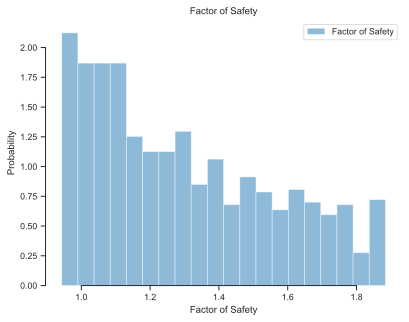

The probability of failure is 11.60%


In [26]:
factor_of_safety = calc_FS(stress_bc, stress_yield)

# Plot the histogram of the factor of safety
fig, ax = plt.subplots()
ax.hist(factor_of_safety, bins=20, density=True, alpha=0.5, label="Factor of Safety")
ax.set_xlabel("Factor of Safety")
ax.set_ylabel("Probability")
ax.set_title("Factor of Safety")
ax.legend()
sns.despine(trim=True)
plt.show()

# Calculate the number of failures
num_failures = np.sum(factor_of_safety < 1)
print(f'The probability of failure is {num_failures/num_samples*100:.2f}%')

This failure rate is much too high! We know that for this application, we would need a different design than what we have above, either by changing to a material with a higher yield strength, increasing the rod diameter to reduce stress, or redesigning the multi-member structure to better distribute the load.

Please find the factor of safety distribution for all three members of our rod, using loops in Python.

In [27]:
# YOUR CODE HERE

### Question 5: Propagating Uncertainty with the Normal Distribution

The Uniform distribution is a good starting point for understanding probability distributions, but it is not always the best choice for modeling real-world data. The Normal distribution is another common probability distribution that is used to model many natural phenomena. The Normal distribution is defined by two parameters, the mean, $\mu$, and the standard deviation, $\sigma$. We say that a random variable $X$ follows a Normal distribution, notated as:

$$
X \sim N(\mu, \sigma)
$$

The Normal distribution is symmetric around the mean, and the probability density function (PDF) is given by:

$$
f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}
$$

Let's visualize the PDF of the Normal distribution with $\mu = 0$ and $\sigma = 1$.

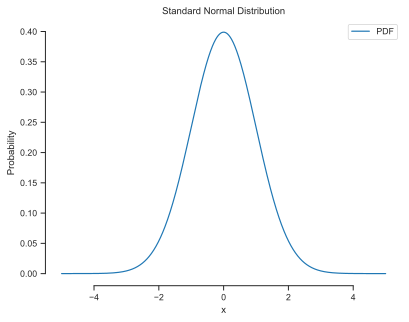

In [29]:
# Define the standard normal distribution
standard_normal = stats.norm(0, 1)

# Generate 1000 points between -5 and 5
x = np.linspace(-5, 5, 1000)

# Calculate the PDF of the standard normal distribution
y = standard_normal.pdf(x)

# Plot the PDF
fig, ax = plt.subplots()
ax.plot(x, y, label="PDF")
ax.set_xlabel("x")
ax.set_ylabel("Probability")
ax.set_title("Standard Normal Distribution")
ax.legend()
sns.despine(trim=True)
plt.show()

I am sure you are familiar with the Normal distribution. Let's generate 1000 samples from the Normal distribution with $\mu = 0$ and $\sigma = 1$ and plot a histogram of the samples.

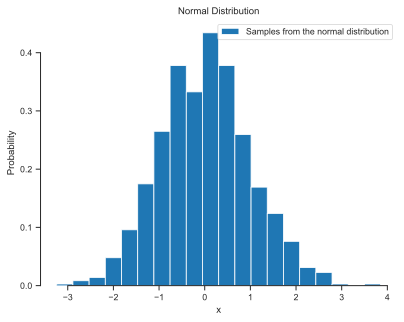

In [30]:
# Set the number of samples that we want to generate
num_samples = 1000

# Seed the PRNG
np.random.seed(42)

# Generate the samples from the normal distribution
samples = np.random.normal(0, 1, num_samples)

# Plot the histogram of the samples
fig, ax = plt.subplots()
ax.hist(samples, bins=20, density=True, label="Samples from the normal distribution")
ax.set_xlabel("x")
ax.set_ylabel("Probability")
ax.set_title("Normal Distribution")
ax.legend()
sns.despine(trim=True)
plt.show()


Now let's imagine that you are manufacturing the rod that we have been discussing. Nominally the rod is 3 inches in diameter, but due to manufacturing tolerances, the diameter can vary. Let's say that the diameter of the rod follows a Normal distribution with $\mu = 3$ inches and $\sigma = 0.5$ inches. Consider the case where the plane is empty, and the force P is 50 kips.

Propagate this uncertainty through each member of the rod, plot the histogram of the factor of safety, and calculate the failure rate.

Would you say that the rod is safe to use with these manufacturing tolerances?

In [31]:
# YOUR CODE HERE